# Linearity measure applied to fashion MNIST
 
## General definition

The model linearity module in alibi provides metric to measure how linear an ML model is. Linearity is defined based on how much the linear superposition of the model's outputs differs from the output of the same linear superposition of the inputs. 

Given $N$ input vectors $v_i$, $N$ real coefficients $\alpha_i$ and a predict function $\text{M}(v_i)$, the linearity of the predict function is defined as

$$L = \Big|\Big|\sum_i \alpha_i M(v_i) - M\Big(\sum_i \alpha_i v_i\Big) \Big|\Big| \quad \quad \text{If M is a regressor}$$

$$L = \Big|\Big|\sum_i \alpha_i \log \circ M(v_i) - \log \circ M\Big(\sum_i \alpha_i v_i\Big)\Big|\Big| \quad \quad \text{If M is a classifier}$$

Note that a lower value of $L$ means that the model $M$ is more linear.


## Alibi implementation
* Based on the general definition above, alibi calculates the linearity of a model in the neighboorhood of a given instance $v_0$. 

## Fashion MNIST data set

* We train a convolutional neural network to classify the images in the fashion MNIST dataset. 

* We investigate the correlation between the model's linearity associated to a certain instance and the class the instance belong to. 

* We also calculate the linearity measure for each internal layer of the CNN and show how linearity propagates through the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf

from alibi.confidence.model_linearity import linearity_measure, LinearityMeasure
from alibi.confidence.model_linearity import _infer_feature_range

from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

## Load data fashion mnist 
The fashion MNIST data set consists of 60000 images of shape $28 \times 28$ divided in 10 categories. Each category corresponds to a different type of clothing piece, such as "boots", "t-shirts", etc

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


Sample instance from the MNIST data set.


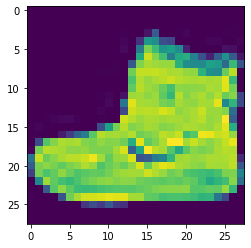

In [4]:
idx = 0
plt.imshow(x_train[idx])
print('Sample instance from the MNIST data set.')

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


## Convolutional neural network
Here we define and train a 2 layer convolutional neural network on the fashion MNIST data set.

### Define model

In [6]:
def model():
    x_in = Input(shape=(28, 28, 1), name='input')
    x = Conv2D(filters=64, kernel_size=2, padding='same', name='conv_1')(x_in)
    x = Activation('relu', name='relu_1')(x)
    x = MaxPooling2D(pool_size=2, name='maxp_1')(x)
    x = Dropout(0.3, name='drop_1')(x)
    
    x = Conv2D(filters=64, kernel_size=2, padding='same', name='conv_2')(x)
    x = Activation('relu', name='relu_2')(x)
    x = MaxPooling2D(pool_size=2, name='maxp_2')(x)
    x = Dropout(0.3, name='drop_2')(x)
    
    x = Flatten(name='flat')(x)
    x = Dense(256, name='dense_1')(x)
    x = Activation('relu', name='relu_3')(x)
    x = Dropout(0.5, name='drop_3')(x)
    x_out = Dense(10, name='dense_2')(x)
    x_out = Activation('softmax', name='softmax')(x_out)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

In [7]:
cnn = model()
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
relu_1 (Activation)          (None, 28, 28, 64)        0         
_________________________________________________________________
maxp_1 (MaxPooling2D)        (None, 14, 14, 64)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        16448     
_________________________________________________________________
relu_2 (Activation)          (None, 14, 14, 64)        0     

### Training

In [8]:
cnn.fit(x_train, y_train, batch_size=64, epochs=5);

Epoch 1/5
60000/60000 [==============================] - 40s 674us/sample - loss: 0.5552 - acc: 0.7955
Epoch 2/5
60000/60000 [==============================] - 43s 717us/sample - loss: 0.3865 - acc: 0.8596
Epoch 3/5
60000/60000 [==============================] - 51s 852us/sample - loss: 0.3421 - acc: 0.8765
Epoch 4/5
60000/60000 [==============================] - 47s 782us/sample - loss: 0.3123 - acc: 0.8851
Epoch 5/5
60000/60000 [==============================] - 48s 802us/sample - loss: 0.2938 - acc: 0.8936


## Linearity of each Layer 
Here we calculate the linearity of the model considering each layer as the output in turn. The values are averaged over 100 random instances sampled from the training set.

### Extract layers

In [9]:
inp = cnn.input
outs = {l.name: l.output for l in cnn.layers}
predict_fns = {name: K.function([inp], [out]) for name, out in outs.items()}

### Calculate linearity

In [10]:
# Infering feature ranges.
features_range = _infer_feature_range(x_test)

# Selecting random instances from training set.
rnd = np.random.randint(len(x_test) - 101, size=100)

In [11]:
lins_layers = {}
for name, l in predict_fns.items():
    if name != 'input':
        def predict_fn(x):
            layer = l([x])
            return layer[0]
        if name == 'softmax':
            lins_layers[name] = linearity_measure(predict_fn, x_test[rnd], feature_range=features_range,
                                                  agg='global', model_type='classifier', nb_samples=20)
        else:
            lins_layers[name] = linearity_measure(predict_fn, x_test[rnd], feature_range=features_range, 
                                                  agg='global', model_type='regressor', nb_samples=20)
lins_layers_mean = {k: v.mean() for k, v in lins_layers.items()}
S = pd.Series(data=lins_layers_mean)

Linearity measure calculated taking as output each layer of a convolutional neural network.


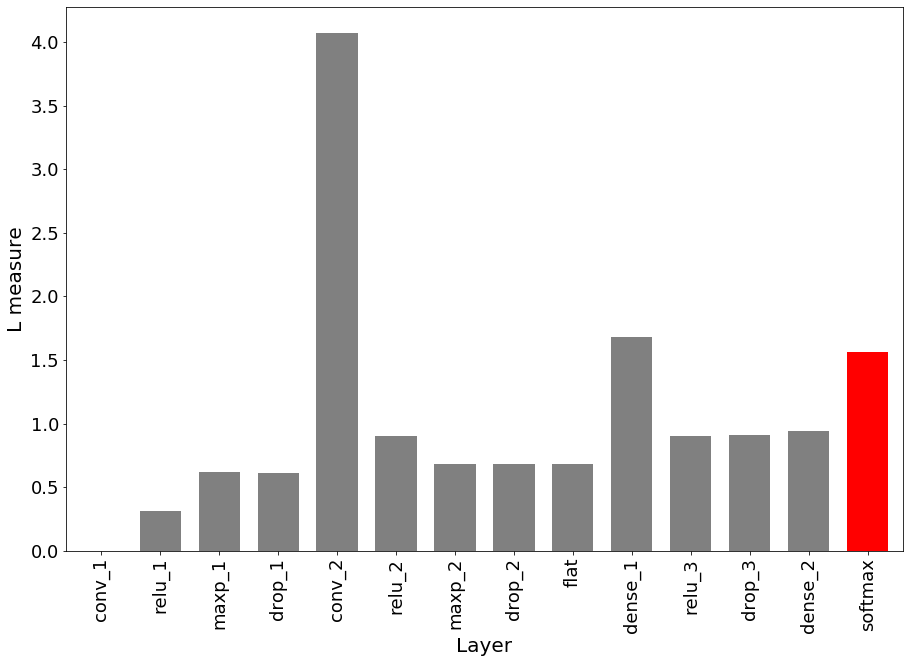

In [12]:
colors = ['gray' for l in S[:-1]]
colors.append('r')
ax = S.plot(kind='bar', linewidth=3, figsize=(15,10), color=colors, width=0.7, fontsize=18)
ax.set_ylabel('L measure', fontsize=20)
ax.set_xlabel('Layer', fontsize=20)
print('Linearity measure calculated taking as output each layer of a convolutional neural network.')

Linearity measure in the locality of a given instance calculated taking as output each layer of a convolutional neural network trained on the fashion MNIST data set.
* The linearity measure of the first convolutional layer conv_1 is 0, as expected since convolutions are linear operations.
* The relu activation introduces non-linearity, which is increased by maxpooling. Dropout layers and flatten layers do no change the output at inference time so the linearity doesn't change.
* The second convolutional layer conv_2 and the dense layers change the linearity even though they are linear operations. 
* The softmax layer in red is obtained by inverting the softmax function. 
* For more details see arxiv reference.

## Linearity and categories
Here we calculate the linearity averaged over all instances belonging to the same class, for each class.

In [13]:
class_groups = []
for i in range(10):
    y = y_test.argmax(axis=1)
    idxs_i = np.where(y == i)[0]
    class_groups.append(x_test[idxs_i])

In [14]:
def predict_fn(x):
    return cnn.predict(x)
lins_classes = []
t_0 = time()
for j in range(len(class_groups)):
    print(f'Calculating linearity for instances belonging to class {j}')
    class_group = class_groups[j]
    class_group = np.random.permutation(class_group)[:2000]
    t_i = time()
    lin = linearity_measure(predict_fn, class_group, feature_range=features_range,
                            agg='global', model_type='classifier', nb_samples=20)
    t_i_1 = time() - t_i
    print(f'Run time for class {j}: {t_i_1}')
    lins_classes.append(lin)
t_fin = time() - t_0
print(f'Total run time: {t_fin}')

Calculating linearity for instances belonging to class 0
Run time for class 0: 2.941605806350708
Calculating linearity for instances belonging to class 1
Run time for class 1: 3.3313376903533936
Calculating linearity for instances belonging to class 2
Run time for class 2: 3.178601026535034
Calculating linearity for instances belonging to class 3
Run time for class 3: 3.324582815170288
Calculating linearity for instances belonging to class 4
Run time for class 4: 3.085338830947876
Calculating linearity for instances belonging to class 5
Run time for class 5: 3.159513473510742
Calculating linearity for instances belonging to class 6
Run time for class 6: 3.4014275074005127
Calculating linearity for instances belonging to class 7
Run time for class 7: 3.3238165378570557
Calculating linearity for instances belonging to class 8
Run time for class 8: 2.9885218143463135
Calculating linearity for instances belonging to class 9
Run time for class 9: 3.4760279655456543
Total run time: 32.223875

In [15]:
df = pd.DataFrame(data=lins_classes).T

Linearity measure distribution means for each class in the fashion MNIST data set.


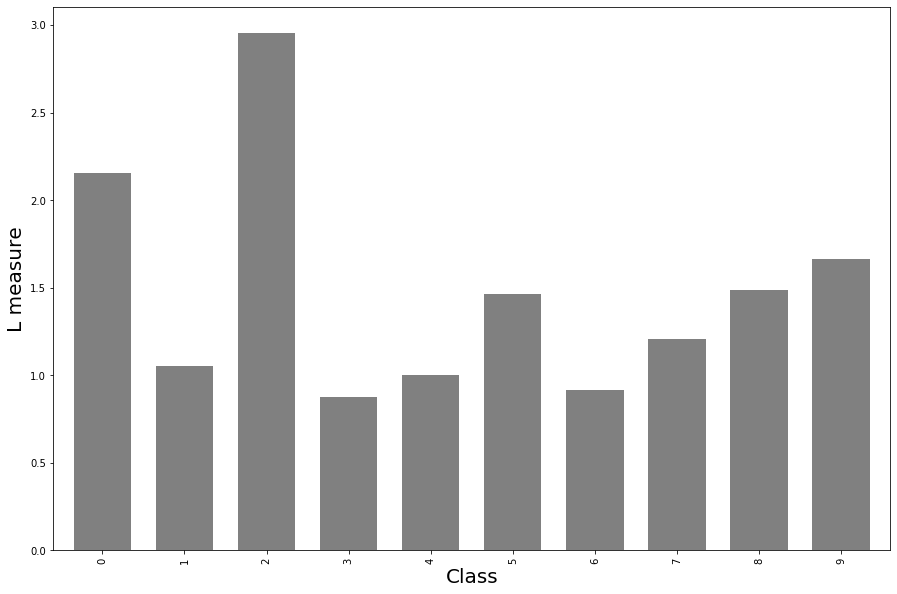

In [16]:
ax = df.mean().plot(kind='bar', linewidth=3, figsize=(15,10), color='gray', width=0.7, fontsize=10)
ax.set_ylabel('L measure', fontsize=20)
ax.set_xlabel('Class', fontsize=20)
print("Linearity measure distribution means for each class in the fashion MNIST data set.")

Linearity measure distributions for each class in the fashion MNIST data set.


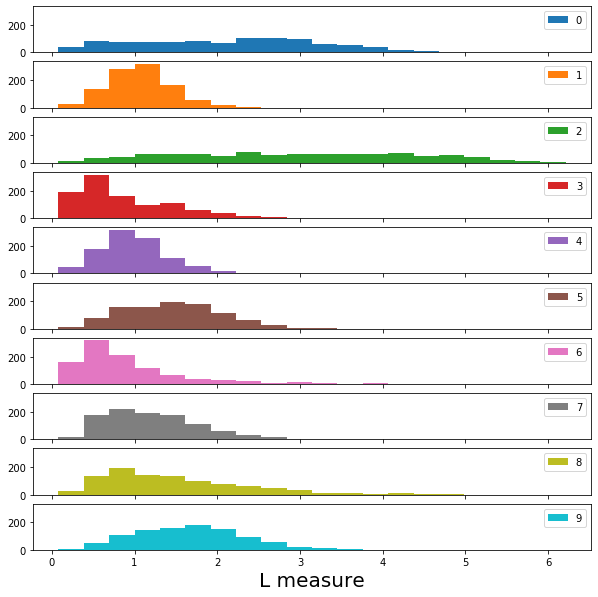

In [17]:
ax2 = df.plot(kind='hist', subplots=True, bins=20, figsize=(10,10), sharey=True)
for a in ax2:
    a.set_xlabel('L measure', fontsize=20)
    a.set_ylabel('', rotation=True, fontsize=10)
#ax2.set_ylabel('F', fontsize=10)
print('Linearity measure distributions for each class in the fashion MNIST data set.')